data science competition: https://www.kaggle.com/competitions/titanic/

22/12/24

Leaderboard: 

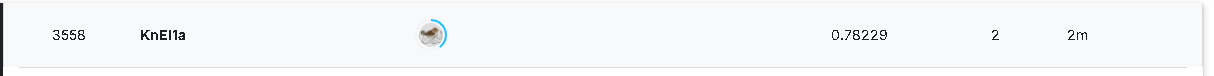

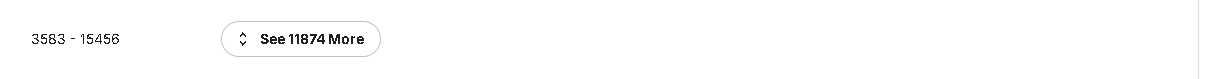

# Upwork, if it was helpful to you <3

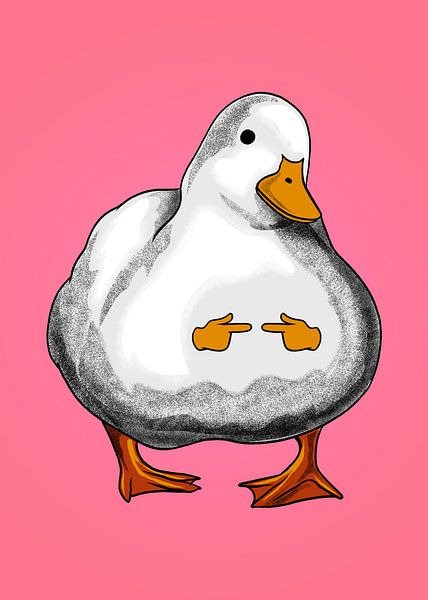



---

# Setup

In [ ]:
import os
import warnings
from pathlib import Path

# Data handling and processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and utilities
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_log_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_predict

# Statsmodels
import statsmodels.api as sm
import tensorflow as tf

# Configure plotting styles
plt.style.use("seaborn-darkgrid")
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [ ]:
def load():
    train = pd.read_csv("/kaggle/input/titanic/train.csv", index_col = "PassengerId")
    test= pd.read_csv("/kaggle/input/titanic/test.csv", index_col = "PassengerId")
    display(train.head(2))
    print("train size: ", train.shape)
    return train,test

train, test = load()

# Data

## duplicated:

In [ ]:
print(train.duplicated().sum())
print(test.duplicated().sum())

## Info and Desc. Statics

In [ ]:
display(train.info())
train.describe().T

## Gaps

In [ ]:
# def missing(df):
#     df.isnull()
def m(train):
    print(train.isnull().mean()*100)
    print(train.isnull().sum())

m(train)
print("test \n")
m(test)

## Cardinality

In [ ]:
train.nunique()

# EDA

## Target

In [ ]:
def target_dist(df = train,target = "Survived"):
    """
    IN
    pandas df with "y"
    target: string type
    """
    
    # Analyze the class distribution
    class_distribution = train[target].value_counts()
    print("Class distribution:\n", class_distribution)
    
    # Identify the majority class
    majority_class = class_distribution.idxmax()
    majority_class_count = class_distribution.max()
    
    # Calculate naive baseline accuracy
    naive_baseline_accuracy = majority_class_count / len(train)
    print(f"Majority class: {majority_class}")
    print(f"Naive baseline accuracy: {naive_baseline_accuracy*100:.2f}%")
    
    # Pie Plot
    
    # Define the labels and sizes for the pie chart
    labels = ['Did not survive', 'Survived']
    sizes = class_distribution.values
    explode = (0.1, 0)  # Highlight the first slice (class 0: Did not survive)
    
    # Create the pie chart
    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
           shadow=True, startangle=90)
    
    # Add a title and show the plot
    ax.set_title('Class Distribution of Survival (Titanic Dataset)')
    plt.show()

print("train")
target_dist()

## Categoricals columns vs target - Bar Plot

In [ ]:
# List of categorical columns
cat_cols = ['Sex', 'Pclass', 'Embarked']

# Iterate through each categorical column
for col in cat_cols:
    # Group by the column and target (Survived), then count occurrences
    category_counts = train.groupby([col, 'Survived']).size().reset_index(name='counts')
    
    # Create a bar plot
    plt.figure(figsize=(8, 6))
    sns.barplot(data=category_counts, x=col, y='counts', hue='Survived', palette='viridis')
    
    # Add title and labels
    plt.title(f'Bar Plot of {col} by Survival')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Survived', loc='upper right')
    
    # Show the plot
    plt.show()

In [ ]:
train.hist(bins = 35)

In [ ]:
sns.histplot(data = train, x = "Age", hue = "Survived")

# Base Line

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time

def simple_decision_tree_pipeline(x_train, y_train, x_test, y_test, feature_engineering_pipeline=None, model = DecisionTreeClassifier(random_state=42)):
    """
    Helper function to train a DecisionTreeClassifier and print out a classification report.

    Parameters:
        x_train: Training feature set.
        y_train: Training target set.
        x_test: Test feature set.
        y_test: Test target set.
        feature_engineering_pipeline: A preprocessing pipeline for feature engineering (optional).
        
    Returns:
        model: The trained DecisionTreeClassifier model.
    """
    # Initialize 
    
    # Record start time
    start_time = time.time()
    
    # Fit feature engineering pipeline and transform data
    if feature_engineering_pipeline:
        parsed_x_train = feature_engineering_pipeline.fit_transform(x_train, y_train)
        parsed_x_test = feature_engineering_pipeline.transform(x_test)
    else:
        parsed_x_train = x_train
        parsed_x_test = x_test
    
    parse_time = time.time()
    print(f"Feature engineering took {(parse_time - start_time):.2f} seconds")
    
    # Train the model
    model.fit(parsed_x_train, y_train)
    fit_time = time.time()
    print(f"Model training took {(fit_time - parse_time):.2f} seconds")
    
    # Generate predictions
    y_pred = model.predict(parsed_x_test)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true=y_test, y_pred=y_pred))
    
    # End time
    end_time = time.time()
    print(f"Overall process took {(end_time - start_time):.2f} seconds")
    
    return model

In [ ]:
X = train.copy()
y = X.pop("Survived")


In [ ]:
numerical_cols = [col for col in X.columns if X[col].dtype != "O"]
categorical_cols = [col for col in X.columns if X[col].dtype == "O"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

## Simple Pipeline test -> NO Feature Eng.

In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Crear los transformadores para cada tipo de columna
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    # ('imputer', KNNImputer(n_neighbors=6)),
    ('discretizer', KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='uniform')),  
    # ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    # ('imputer', KNNImputer(n_neighbors=6)),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))  
    # ('target_encoder', ce.TargetEncoder())
])

from sklearn.feature_selection import mutual_info_classif


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),  # Aplicar discretización y escalado a las columnas numéricas
        ('cat', categorical_transformer, categorical_cols)  # Codificar las variables categóricas
    ])

model = simple_decision_tree_pipeline(X_train, y_train, X_test, y_test, feature_engineering_pipeline=preprocessor)

# Modeling

#### Conclusion: We stick with the first option. Without feature engineering with classical imputation by median and "most_freq"

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def compare_models_with_cv(X, y, preprocessor, numerical_cols, categorical_cols):
    """
    Compara el rendimiento de varios modelos para clasificación binaria con validación cruzada
    y ajuste básico de hiperparámetros, retornando los modelos entrenados con sus mejores parámetros.
    """
    models = {
        'LogisticRegression': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['liblinear', 'lbfgs']
            }
        },
        'XGBoost': {
            'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic', random_state=42),
            'params': {
                'n_estimators': [50, 100],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5]
            }
        },
        'LightGBM': {
            'model': LGBMClassifier(verbose=-1, objective='binary'),
            'params': {
                'n_estimators': [50, 100],
                'learning_rate': [0.01, 0.1],
                'max_depth': [-1, 10]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance']
            }
        },
        'DecisionTree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 10]
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [3, 5, 10],
                'min_samples_split': [2, 10]
            }
        }
    }
    
    models_trained = {}

    for name, config in models.items():
        print(f"\nTraining {name}...")

        # Usar el preprocesador y GridSearchCV
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', config['model'])])
        grid = GridSearchCV(estimator=pipeline, param_grid={'model__' + k: v for k, v in config['params'].items()},
                            cv=5, scoring='accuracy', n_jobs=-1)
        grid.fit(X, y)
        best_model = grid.best_estimator_
        best_params = grid.best_params_

        models_trained[name] = {
            'best_model': best_model,
            'best_params': best_params
        }

        print(f"{name}: Best Params: {best_params}")

    return models_trained

# Ejemplo de uso
X = train.copy()
y = X.pop("Survived")
numerical_cols = [col for col in X.columns if X[col].dtype != "O"]
categorical_cols = [col for col in X.columns if X[col].dtype == "O"]

models_trained = compare_models_with_cv(X, y, preprocessor, numerical_cols, categorical_cols)



In [ ]:
from sklearn.metrics import accuracy_score

for name, model_info in models_trained.items():
    print(f"\n{name} model trained with best parameters: {model_info['best_params']}")
    
    # Predicciones en los datos de prueba
    predictions = model_info['best_model'].predict(X_test)
    
    # Calcular la precisión (accuracy)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy:.4f}")


In [ ]:
from sklearn.ensemble import VotingClassifier


voting_clf = VotingClassifier(
    estimators=[(name, model_info['best_model']) for name, model_info in models_trained.items()],
    voting='hard'  # Usamos el voto por mayoría ('hard') o puedes cambiar a 'soft' si prefieres probabilidades
)


voting_clf.fit(X, y)


voting_predictions = voting_clf.predict(X_test)


voting_accuracy = accuracy_score(y_test, voting_predictions)
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")


In [ ]:
test.index

In [ ]:
vot_testpred = voting_clf.predict(test)
vot_testpred

In [ ]:

d = {'PassengerId': test.index, 'Survived': vot_testpred}


df = pd.DataFrame(data=d)


submission = df.to_csv('submission.csv', index=False)

